In [1]:
import torch
torch.manual_seed(38)
from torch.utils.data import Dataset, DataLoader
from evaluate import evaluate
from model_utils import load_checkpoint
import net
from data_loader import *
import torch.optim as optim
import torch.nn as nn
import os
import cv2
import sys
sys.path.append("..")
from utils import adjustColor, plot_histogram, plot_histogram_normalized, print_stat, add_window
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('../Google_HDRplus/')
from hdrplus import HDRPlus_model
import json

In [2]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args("")
with open('args.json', 'r') as f:
    args.__dict__ = json.load(f)

# args.__dict__['merge_ver']='mp'
print(args)

Namespace(alternate_corr=False, ckpt_dir='ckpt/1003_00_42/', logs_dir='runs/1003_00_42/', merge_ver='p', mixed_precision=False, model_dir='.', note=None, restore_file='last', small=False)


In [3]:
model = net.Net(args).cuda()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-4)
loss_fn = nn.L1Loss()

In [4]:
restore_path = os.path.join('ckpt/1003_00_42/', 'best.pth.tar')

# 0922_20_45 : merge_mask
# 0928_19_43 : merge_mask w/ RAFT
# 0929_12_08 : merge_mask w/ RAFT train on larger dataset
# -------------- above are with mergenetM (conv4 filter_size = 1)
# 1003_00_18 : mergenetMP w layer6
# 1003_00_20 : mergenetMP w/o layer5&6
# 1003_00_42 : mergenet-[p]
# 1003_00_42t : mergenet-[p] fine-tuned on input_2.npy
model, optimizer, start_epoch, best_val_loss = load_checkpoint(restore_path, model, optimizer)
print("epoch:", start_epoch)

[*] Loaded model from ckpt/1003_00_42/best.pth.tar
epoch: 491


In [5]:
eval_transformer =  GroupComposed([
    GroupToPILImage(mode = 'F'),
#     GroupRawRandomCrop(2048), ## random crop may cause broken Bayer pattern
    GroupToTensor()
])
dataloader = DataLoader(HDRDataset(eval_transformer, 1),
                            batch_size = 1, shuffle = True,
                            num_workers = int(8),
                            pin_memory=True)
# dataloader =  DataLoader(LlrawSet(transform = eval_transformer, n_samples=1,frame_per_sample = 8, pos = 'mid'),
#                  batch_size = 1, shuffle = True,
#                  num_workers = int(8),
#                  pin_memory=True)
dataiter = iter(dataloader)

7783


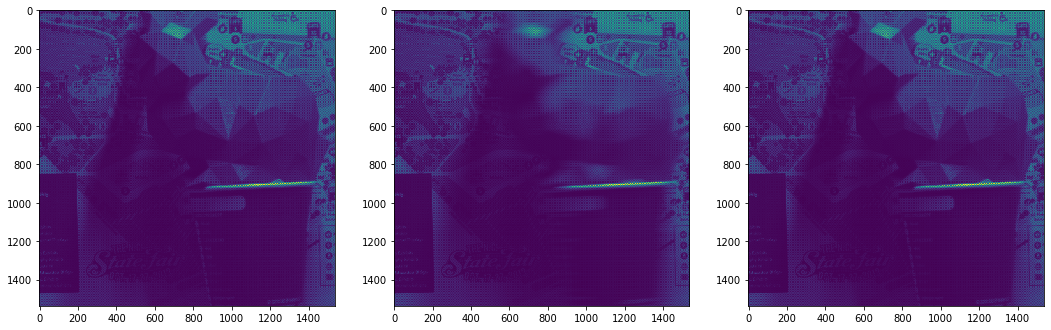

In [6]:
# for i in range(50):
window_size = 1536
val_batch, labels_batch = dataiter.next()
val_batch = val_batch[:, :, 512:512+window_size, 1536:1536+window_size]#.pow(1/2.2)

labels_batch = labels_batch[:, :, 512:512+window_size, 1536:1536+window_size]#.pow(1/2.2)

gamma_val = 2.2
bit_depth = 10
n_frames = 8

ref = (val_batch[0, 0].numpy() * (2**bit_depth-1)).astype(np.uint16)
avg = (np.mean(val_batch[0, :].numpy(), axis = 0)* (2**bit_depth*n_frames-1)).astype(np.uint16)
gt = (labels_batch[0, 0].cpu().numpy()* (2**bit_depth*n_frames-1)).astype(np.uint16)
print(gt.max())
fig, ax = plt.subplots(1, 3, figsize=(18, 10)) ## different figure size may lead to block-like display. Dont know why.
ax[0].imshow(ref)
ax[1].imshow(avg)
ax[2].imshow(gt)
plt.show()

## Ground Truth

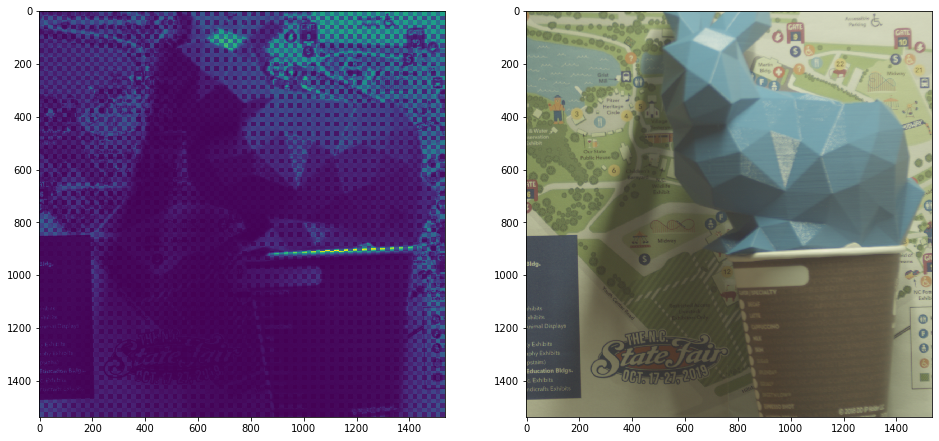

In [7]:
# rgb_gt = demosaic(gt)
rgb_gt = cv2.cvtColor(gt, cv2.COLOR_BAYER_RG2RGB)
rgb_gt = adjustColor(rgb_gt,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = gamma_val, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(gt)
ax[1].imshow(rgb_gt)
plt.show()

gt shape:  (1536, 1536) dtype: uint16
gt stat: max: 7783, min: 34, mean: 747.5776176452637, std: 861.6524910446182


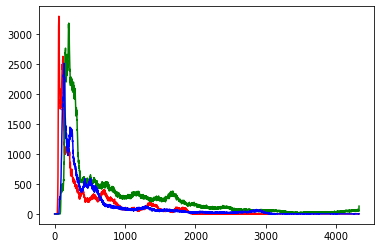

In [8]:
print_stat("gt", gt)
plot_histogram(gt, bit_depth + np.log(n_frames))
# plt.savefig('gt_hist.png')

## prediction

In [9]:
cuda=True
model.eval()

with torch.no_grad():
#     for i, (val_batch, labels_batch) in enumerate(dataloader):
#         val_batch = val_batch[:, :, :1024, :1024]
#         labels_batch = labels_batch[:, :, :1024, :1024]
    n_seq = val_batch.size(1)
    output_batch = val_batch[:, 0:1].clone()
#     if cuda:
#         output_batch = output_batch.cuda(non_blocking=True)
#     val_batch_cuda = val_batch.cuda(non_blocking=True)
    for j in range(1, n_seq):
        print("processing {}th image....".format(j))
        input_batch = val_batch[:, [0, j]]#torch.cat([val_batch_cuda[:, 0:1], val_batch_cuda[:, j:j+1]], dim = 1)
        if cuda:
#             input_batch, labels_batch = input_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
            input_batch = input_batch.cuda(non_blocking=True)

#         res = model(input_batch)
#                 output_batch = res
        output_batch += model(input_batch).detach().cpu()
#             #########
#             output_batch = torch.sigmoid(output_batch)
    output_batch = output_batch/float(n_seq)
    output_batch = torch.clamp(output_batch, min=0., max=1.)

processing 1th image....
processing 2th image....
processing 3th image....
processing 4th image....
processing 5th image....
processing 6th image....
processing 7th image....


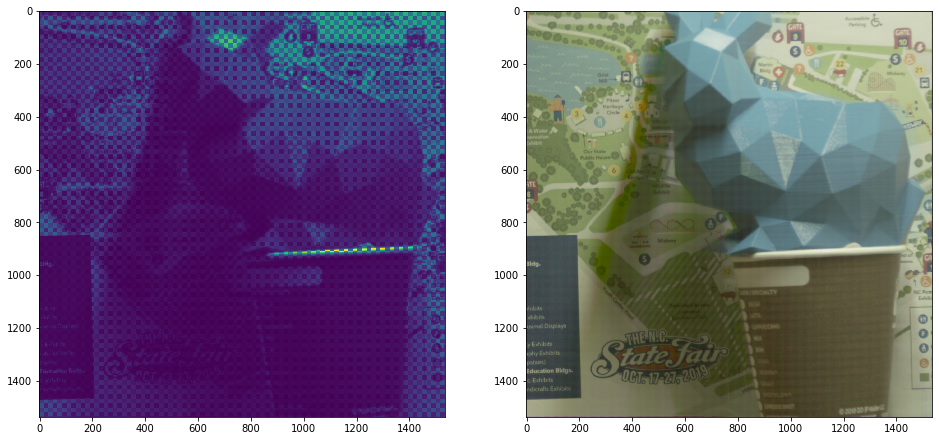

In [10]:
output = (output_batch[0, 0].detach().numpy() * (2**bit_depth*n_frames-1)).astype(np.uint16)
rgb_output = cv2.cvtColor(output, cv2.COLOR_BAYER_RG2RGB)
rgb_output = adjustColor(rgb_output,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = gamma_val, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(output)
ax[1].imshow(rgb_output)
plt.show()

output shape:  (1536, 1536) dtype: uint16
output stat: max: 8191, min: 0, mean: 796.7929284837511, std: 939.8229366591896
loss =  71.40818956163194


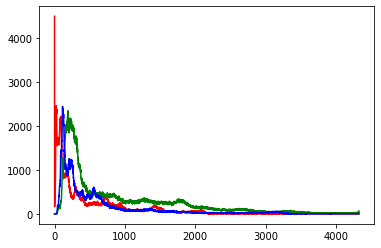

In [11]:
print_stat("output", output)
plot_histogram(output, bit_depth + np.log(n_frames))
loss = np.abs(output.astype(np.int16)-gt.astype(np.int16)).mean()
print("loss = ", loss)
# plt.savefig('output_hist.png')

## 8 frames average

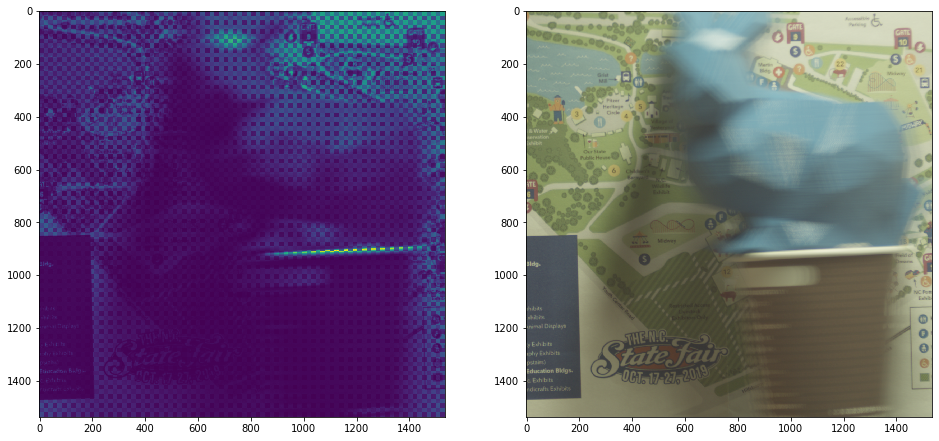

In [12]:
rgb_avg = cv2.cvtColor(avg, cv2.COLOR_BAYER_RG2RGB)
rgb_avg = adjustColor(rgb_avg,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = gamma_val, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(avg)
ax[1].imshow(rgb_avg)
plt.show()

avg shape:  (1536, 1536) dtype: uint16
avg stat: max: 7783, min: 35, mean: 747.3622898525662, std: 832.017454031025


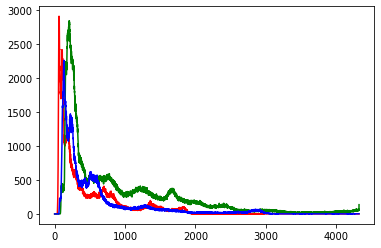

In [13]:
print_stat("avg", avg)
plot_histogram(avg, bit_depth + np.log(n_frames))
# plt.savefig('avg_hist.png')

## single frame

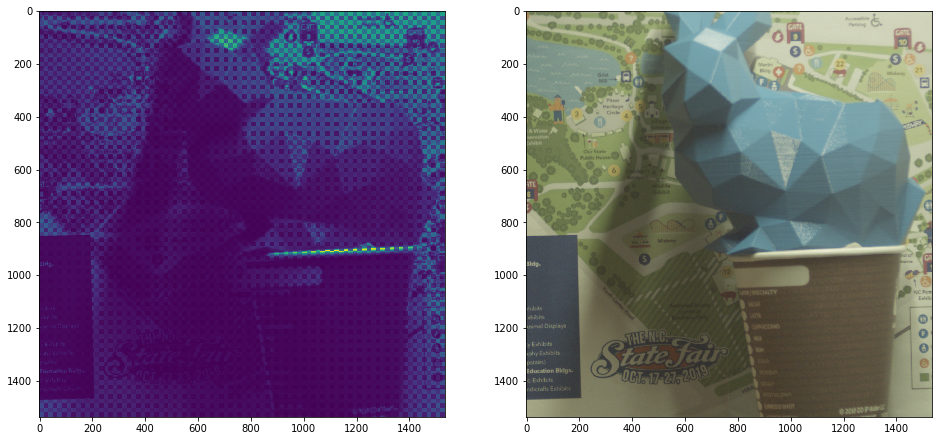

In [14]:
rgb_ref = cv2.cvtColor(ref, cv2.COLOR_BAYER_RG2RGB)
rgb_ref = adjustColor(rgb_ref,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = gamma_val, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(ref)
ax[1].imshow(rgb_ref)
plt.show()

ref shape:  (1536, 1536) dtype: uint16
ref stat: max: 972, min: 2, mean: 92.44213485717773, std: 107.60712502147666


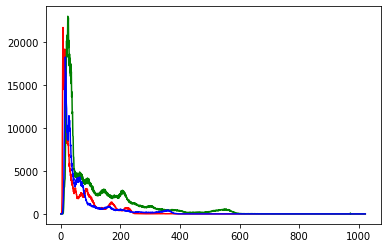

In [15]:
print_stat("ref", ref)
plot_histogram(ref, bit_depth)
# plot_histogram(_inputs[0], 5)
# plt.savefig('ref_hist.png')

## HDRPlus

In [27]:
# dataiter = iter(dataloader)
# val_batch, labels_batch = dataiter.next()
# val_batch = val_batch#[:, :, :2048, :3584]
# labels_batch = labels_batch#[:, :, :2048, :3584]
val_imgs = (val_batch[0].numpy() * (2**bit_depth -1)).astype(np.uint16)
output_hdrplus = HDRPlus_model(val_imgs).astype(np.uint16)

merging 1th alternative frame
merging 2th alternative frame
merging 3th alternative frame
merging 4th alternative frame
merging 5th alternative frame
merging 6th alternative frame
merging 7th alternative frame


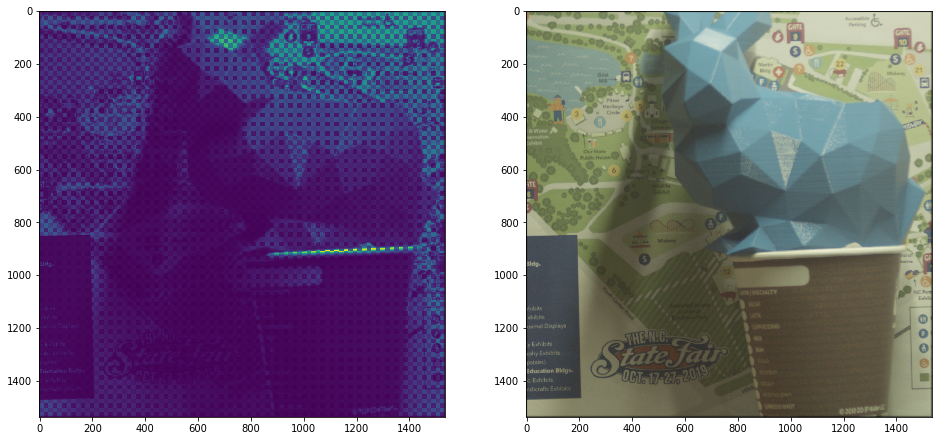

In [28]:
rgb_hdrp = cv2.cvtColor(output_hdrplus, cv2.COLOR_BAYER_RG2RGB)
rgb_hdrp = adjustColor(rgb_hdrp,rc = 1, bc = 1, gc = 0.7, gain=1.3, gamma = gamma_val, contrast=1.5)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(output_hdrplus)
ax[1].imshow(rgb_hdrp)
plt.show()

output_hdrplus shape:  (1536, 1536) dtype: uint16
output_hdrplus stat: max: 7776, min: 7, mean: 728.2955546908909, std: 850.5922831090486
loss=  32.847094217936196


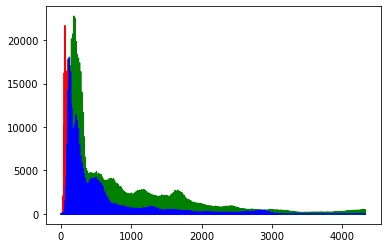

In [32]:
print_stat("output_hdrplus", output_hdrplus)
plot_histogram(output_hdrplus, bit_depth + np.log(n_frames))
# plt.savefig('hdrp_hist.png')
loss = np.abs(output_hdrplus.astype(np.int16)-gt.astype(np.int16)).mean()
print("loss= ", loss)

(array([1.655029e+06, 3.841840e+05, 1.836350e+05, 7.557000e+04,
        2.133700e+04, 3.464300e+04, 3.055000e+03, 7.340000e+02,
        5.010000e+02, 6.080000e+02]),
 array([7.0000e+00, 7.8390e+02, 1.5608e+03, 2.3377e+03, 3.1146e+03,
        3.8915e+03, 4.6684e+03, 5.4453e+03, 6.2222e+03, 6.9991e+03,
        7.7760e+03]),
 <a list of 10 Patch objects>)

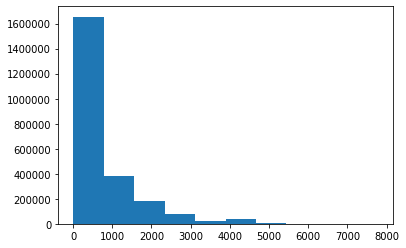

In [33]:
plt.hist(output_hdrplus.flatten())

## comparison

From left to right: ref, hdr+ frame, pred frame, gt

In [19]:
# fig, ax = plt.subplots(3, 4, figsize=(20, 16))
# ax[0][0].imshow(rgb_ref[100:100+256, 155:155+256])
# ax[0][1].imshow(rgb_hdrp[100:100+256, 155:155+256])
# ax[0][2].imshow(rgb_output[100:100+256, 155:155+256])
# ax[0][3].imshow(rgb_gt[100:100+256, 155:155+256])
# ax[1][0].imshow(rgb_ref[750:750+256, 400:400+256])
# ax[1][1].imshow(rgb_hdrp[750:750+256, 400:400+256])
# ax[1][2].imshow(rgb_output[750:750+256, 400:400+256])
# ax[1][3].imshow(rgb_gt[750:750+256, 400:400+256])
# ax[2][0].imshow(rgb_ref[400:400+256, 600:600+256])
# ax[2][1].imshow(rgb_hdrp[400:400+256, 600:600+256])
# ax[2][2].imshow(rgb_output[400:400+256, 600:600+256])
# ax[2][3].imshow(rgb_gt[400:400+256, 600:600+256])
# plt.show()

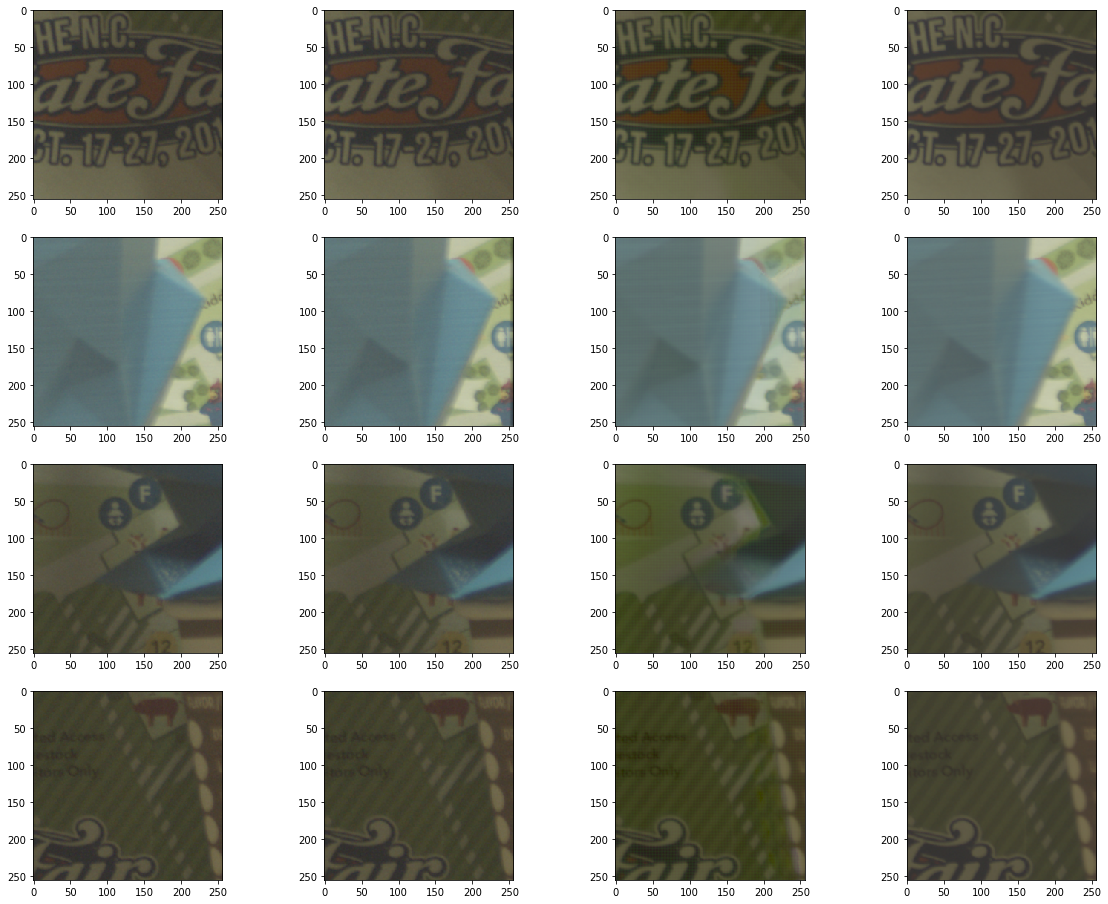

In [20]:
fig, ax = plt.subplots(4, 4, figsize=(20, 16))
ax[0][0].imshow(rgb_ref[1200:1200+256, 400:400+256])
ax[0][1].imshow(rgb_hdrp[1200:1200+256, 400:400+256])
ax[0][2].imshow(rgb_output[1200:1200+256, 400:400+256])
ax[0][3].imshow(rgb_gt[1200:1200+256, 400:400+256])
ax[1][0].imshow(rgb_ref[600:600+256, 1280:1280+256])
ax[1][1].imshow(rgb_hdrp[600:600+256, 1280:1280+256])
ax[1][2].imshow(rgb_output[600:600+256, 1280:1280+256])
ax[1][3].imshow(rgb_gt[600:600+256, 1280:1280+256])
ax[2][0].imshow(rgb_ref[1250-512:1250-512+256, 1100-512:1100-512+256])
ax[2][1].imshow(rgb_hdrp[1250-512:1250-512+256, 1100-512:1100-512+256])
ax[2][2].imshow(rgb_output[1250-512:1250-512+256, 1100-512:1100-512+256])
ax[2][3].imshow(rgb_gt[1250-512:1250-512+256, 1100-512:1100-512+256])
ax[3][0].imshow(rgb_ref[1050:1050+256, 600:600+256])
ax[3][1].imshow(rgb_hdrp[1050:1050+256, 600:600+256])
ax[3][2].imshow(rgb_output[1050:1050+256, 600:600+256])
ax[3][3].imshow(rgb_gt[1050:1050+256, 600:600+256])
plt.show()

#### save images

In [21]:
# def draw_boxes(img):
#     img = add_window(img, 100, 155, 'r', win_size = 180)
#     img = add_window(img, 800, 400, 'g', win_size = 180)
#     img = add_window(img,400, 600, 'c', win_size = 180)
#     return img

In [22]:
# rgb_gt_w_win = draw_boxes(rgb_gt)
# fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# ax[0].imshow(rgb_gt_w_win)
# ax[1].imshow(rgb_gt)
# plt.show()
# # cv2.imwrite("rgb_gt", rgb_gt

In [23]:
# cv2.imwrite("rgb_gt.png", rgb_gt[..., ::-1])
# cv2.imwrite("rgb_gt_wbox.png", draw_boxes(rgb_gt)[..., ::-1])

# cv2.imwrite("rgb_ref.png", rgb_ref[..., ::-1])
# cv2.imwrite("rgb_ref_wbox.png", draw_boxes(rgb_ref)[..., ::-1])

# cv2.imwrite("rgb_hdrp.png", rgb_hdrp[..., ::-1])
# cv2.imwrite("rgb_hdrp_wbox.png", draw_boxes(rgb_hdrp)[..., ::-1])

# cv2.imwrite("rgb_output.png", rgb_output[..., ::-1])
# cv2.imwrite("rgb_output_wbox.png", draw_boxes(rgb_output)[..., ::-1])

# cv2.imwrite("rgb_avg.png", rgb_avg[..., ::-1])
# cv2.imwrite("rgb_avg_wbox.png", draw_boxes(rgb_avg)[..., ::-1])

In [24]:
# def save_imgs(name, img):
#     cv2.imwrite(name+"_p1.png", img[100:100+180, 155:155+180, ::-1])
#     cv2.imwrite(name+"_p2.png", img[800:800+180, 400:400+180, ::-1])
#     cv2.imwrite(name+"_p3.png", img[400:400+180, 600:600+180, ::-1])

In [25]:
# save_imgs("rgb_gt", draw_boxes(rgb_gt))
# save_imgs("rgb_ref", draw_boxes(rgb_ref))
# save_imgs("rgb_hdrp", draw_boxes(rgb_hdrp))
# save_imgs("rgb_output", draw_boxes(rgb_output))
# save_imgs("rgb_avg", draw_boxes(rgb_avg))